In [26]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, precision_score, classification_report
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
#reading data from my google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
!ls '/content/drive/MyDrive/Capstone/brain'

Testing  Training


In [29]:
train_folder = '/content/drive/MyDrive/Capstone/brain/Training'
test_folder = '/content/drive/MyDrive/Capstone/brain/Testing'

In [30]:
#function to read in the images and labels
def read_images(folder):
  images = []
  labels = []
  for tumor in os.listdir(folder): #gives a list of the files in this path - all the tumor folders
    tumor_path = os.path.join(folder, tumor) #gives us the path to each tumor folder
    if os.path.isdir(tumor_path): #if this is an existing path, then proceed
      for file in os.listdir(tumor_path): #list of the files in the tumor path - testing and training in each tumor file
        tumor_image_path = os.path.join(tumor_path, file) #getting the specific path to the images
        tumor_image = image.load_img(tumor_image_path, target_size=(224, 224)) #loading image and setting target size to reshape later
        images.append(image.img_to_array(tumor_image)) #adding all the images to the images list and converting the image to an array
        labels.append(tumor) #adding labels (names of tumors) to the labels list
  images = np.array(images)
  labels = np.array(labels)
  return images, labels

In [31]:
#training data
X_train, y_train = read_images(train_folder)
X_train, y_train = shuffle(X_train, y_train, random_state=42)

#testing data
X_test, y_test = read_images(test_folder)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

y_train_encoded = pd.get_dummies(y_train)
y_test_encoded = pd.get_dummies(y_test)

In [32]:
X_train.shape, y_train_encoded.shape

((5714, 224, 224, 3), (5714, 4))

In [33]:
X_train = X_train / 255
X_test = X_test / 255

In [34]:
#testing model 2 using EarlyStop
model2 = Sequential()

n_input2 = X_train.shape[1]

model2.add(Flatten(input_shape=(X_train.shape[1:])))
model2.add(Dense(25, input_dim=n_input2, activation='relu'))
model2.add(Dense(12, activation='relu'))
model2.add(Dense(4, activation='softmax'))

In [35]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

In [36]:
history2 = model2.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), batch_size=None, epochs=10, callbacks=es)

Epoch 1/10
179/179 [==============================] - 4s 20ms/step - loss: 1.8515 - acc: 0.5613 - val_loss: 1.0755 - val_acc: 0.6796
Epoch 2/10
179/179 [==============================] - 2s 12ms/step - loss: 0.8160 - acc: 0.7191 - val_loss: 0.8709 - val_acc: 0.7605
Epoch 3/10
179/179 [==============================] - 2s 12ms/step - loss: 0.6321 - acc: 0.7692 - val_loss: 0.9798 - val_acc: 0.7025
Epoch 4/10
179/179 [==============================] - 2s 12ms/step - loss: 0.6698 - acc: 0.7709 - val_loss: 0.6671 - val_acc: 0.7857
Epoch 5/10
179/179 [==============================] - 2s 12ms/step - loss: 0.5176 - acc: 0.8239 - val_loss: 0.7456 - val_acc: 0.7399
Epoch 6/10
179/179 [==============================] - 2s 12ms/step - loss: 0.4548 - acc: 0.8386 - val_loss: 0.7850 - val_acc: 0.7216
Epoch 7/10
179/179 [==============================] - 2s 12ms/step - loss: 0.4099 - acc: 0.8549 - val_loss: 0.4835 - val_acc: 0.8383
Epoch 8/10
179/179 [==============================] - 2s 12ms/step - 

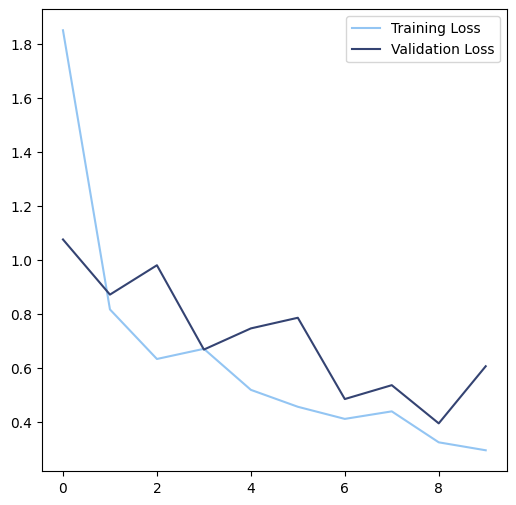

In [37]:
plt.figure(figsize=(6, 6))
plt.plot(history2.history['loss'], c='#93C5F3', label='Training Loss')
plt.plot(history2.history['val_loss'], c='#344372', label='Validation Loss')
plt.legend();

In [38]:
model2.evaluate(X_test, y_test_encoded)

41/41 [==============================] - 0s 8ms/step - loss: 0.6052 - acc: 0.8238


[0.6052013039588928, 0.823798656463623]

In [39]:
y_pred2 = model2.predict(X_test)
#y_pred2

41/41 [==============================] - 0s 7ms/step


In [40]:
y_prediction2 = np.argmax(y_pred2, axis=1)
y_prediction2

array([2, 2, 0, ..., 2, 0, 2])

In [41]:
y_true2 = np.argmax(y_test_encoded.values, axis=1)
y_true2

array([2, 2, 0, ..., 2, 1, 2])

In [42]:
matrix2 = confusion_matrix(y_true2, y_prediction2)
matrix2

array([[282,   9,   3,   6],
       [141, 116,  34,  15],
       [  3,   0, 402,   0],
       [ 18,   0,   2, 280]])

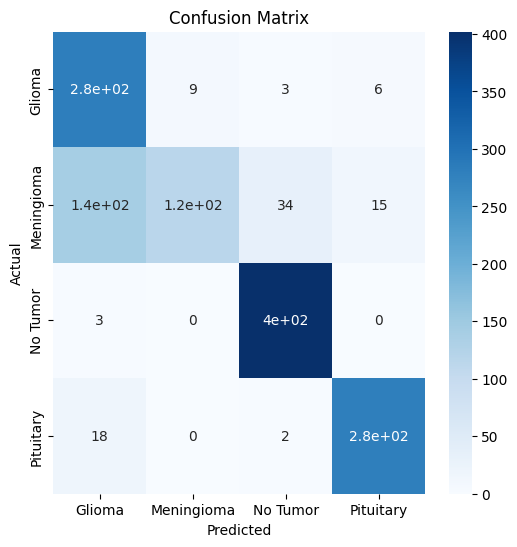

In [43]:
#plotting the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(matrix2, annot=True, cmap='Blues', xticklabels=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'], yticklabels=['Glioma', 'Meningioma', 'No Tumor', 'Pituitary'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [44]:
model2_precision = precision_score(y_true2, y_prediction2, average=None)
model2_precision

array([0.63513514, 0.928     , 0.91156463, 0.93023256])

In [45]:
model2_accuracy = accuracy_score(y_true2, y_prediction2)
model2_accuracy

0.8237986270022883

In [46]:
model2_recall = recall_score(y_true2, y_prediction2, average=None)
model2_recall

array([0.94      , 0.37908497, 0.99259259, 0.93333333])

In [47]:
model2_f1_score = f1_score(y_true2, y_prediction2, average=None)
model2_f1_score

array([0.75806452, 0.53828306, 0.95035461, 0.93178037])

In [48]:
#baseline scores
random_classifier = DummyClassifier(strategy="uniform")
random_classifier.fit(X_train, y_train_encoded)

DummyClassifier(strategy='uniform')

In [49]:
random_prediction = random_classifier.predict(X_test)

In [50]:
report = classification_report(y_test_encoded, random_prediction)
print(report)

              precision    recall  f1-score   support

           0       0.24      0.53      0.33       300
           1       0.24      0.53      0.33       306
           2       0.33      0.52      0.40       405
           3       0.24      0.50      0.33       300

   micro avg       0.26      0.52      0.35      1311
   macro avg       0.26      0.52      0.35      1311
weighted avg       0.27      0.52      0.35      1311
 samples avg       0.25      0.52      0.32      1311



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
